# API usage example

The goal of this document is to present Ultrack's programming interface regarding its API capabilities.

We define Ultrack's API as a server-client model where a server is generally instantiated on a machine for computing, and the client is another machine that can send tracking requests to the server. Alternatively, one can use one machine for both server and client capabilities, which can be useful for communication over different languages, such as the [Ultrack plugin for ImageJ/FIJI](https://github.com/royerlab/ultrack-imagej). One important thing worth mentioning is that the API **does not send the image data** over the communication since the data can be quite large. In that sense, the data you request to track must be reachable for the server, such as a shared file system or [in the cloud](https://ome-zarr.readthedocs.io/en/stable/). 

Throughout this document, we will provide examples for both server instantiation and client requisition.

First, as usual, we download the demonstration dataset.

In [1]:
import tempfile

import toml
!wget -nc http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DL-HeLa.zip
!unzip -n Fluo-N2DL-HeLa.zip

File ‘Fluo-N2DL-HeLa.zip’ already there; not retrieving.

Archive:  Fluo-N2DL-HeLa.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of Fluo-N2DL-HeLa.zip or
        Fluo-N2DL-HeLa.zip.zip, and cannot find Fluo-N2DL-HeLa.zip.ZIP, period.


We set some environment variables and import the required python packages.

In [1]:
import os
from pathlib import Path
import json
import time
import sys
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from IPython.display import clear_output

import napari
import numpy as np
import pandas as pd
from napari.utils.notebook_display import nbscreenshot
from tifffile import imwrite
from rich.pretty import pprint
import networkx as nx
from networkx.readwrite import json_graph
import asyncio
import websockets
from websockets.exceptions import ConnectionClosedError
import requests

from ultrack.api import start_server, Experiment as APIExperiment, ExperimentStatus
from ultrack.config import MainConfig, DataConfig

## 1. Instantiating the server

Now, we can start our server to listen for connections.

But first, we should configure the parameters of `MainConfig` object for all track requests. For further information, check the [ultrack configuration docs](https://royerlab.github.io/ultrack/configuration.html).

In [5]:
# we load the default configuration
config = MainConfig()

# we set the data configuration
config.data_config.working_dir = "."  # The working directory where the server will store the data as a `data.db` file
config.data_config.database = "sqlite"  # The database to use. In this case, we use a sqlite database
config.data_config.n_workers = 8  # The number of workers to use for the db operations

Now, we can finally start our server in the port `8125` (or any other you prefer).

In [8]:
import subprocess
import tempfile

import toml

port = 8125

# We dump the data config to a temporary file. In a real scenario, you would save this file for future use.
with tempfile.NamedTemporaryFile("w", delete=False, suffix=".toml") as f:
    toml.dump(config.dict(by_alias=True), f)
    config_path = f.name

# run `ultrack server --port ??? --config_path ???` command
process = subprocess.Popen(["ultrack", "server", "--port", f"{port}", "--config", f"{config_path}"], 
                           stdout=subprocess.PIPE, stderr=subprocess.PIPE)

Ultrack server has started! Now we can check its outputs in the following cell.
This cell will continue printing the server output and we start making the request along the example.

In [9]:
import threading

def read_output(stream, label):
    """Read from a stream and print each line with a label."""
    for line in iter(stream.readline, b''):
        print(f"{label}: {line.decode().strip()}")

stdout_thread = threading.Thread(target=read_output, args=(process.stdout, 'STDOUT'))
stderr_thread = threading.Thread(target=read_output, args=(process.stderr, 'STDERR'))

stdout_thread.start()
stderr_thread.start()

STDERR: INFO:     Started server process [289312]
STDERR: INFO:     Waiting for application startup.
STDERR: INFO:     Application startup complete.
STDERR: INFO:     Uvicorn running on http://0.0.0.0:8125 (Press CTRL+C to quit)
STDOUT: INFO:     127.0.0.1:53724 - "GET /config/default HTTP/1.1" 200 OK
STDERR: INFO:     ('127.0.0.1', 58680) - "WebSocket /segment/auto_detect" [accepted]
STDERR: INFO:     connection open
STDOUT: Set parameter Username
STDOUT: Academic license - for non-commercial use only - expires 2025-01-18
STDOUT: Set parameter TimeLimit to value 36000
STDOUT: Set parameter NodeLimit to value 1073741824
STDOUT: Set parameter SolutionLimit to value 1073741824
STDOUT: Set parameter IntFeasTol to value 1e-06
STDOUT: Set parameter Method to value 3
STDOUT: Set parameter MIPGap to value 0.001
STDOUT: Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")
STDOUT: 
STDOUT: CPU model: 12th Gen Intel(R) Core(TM) i7-12700F, instruction set [SSE2|AVX|AV

Now you should see something like `Uvicorn running on http://0.0.0.0:8125` in the last message. That indicates that the start was successful and the server is ready to receive jobs!

## 2. Submitting our first tracking job

Now that the server is up and running, we can submit our tracking jobs.
As an example, we will use the dataset previously downloaded.

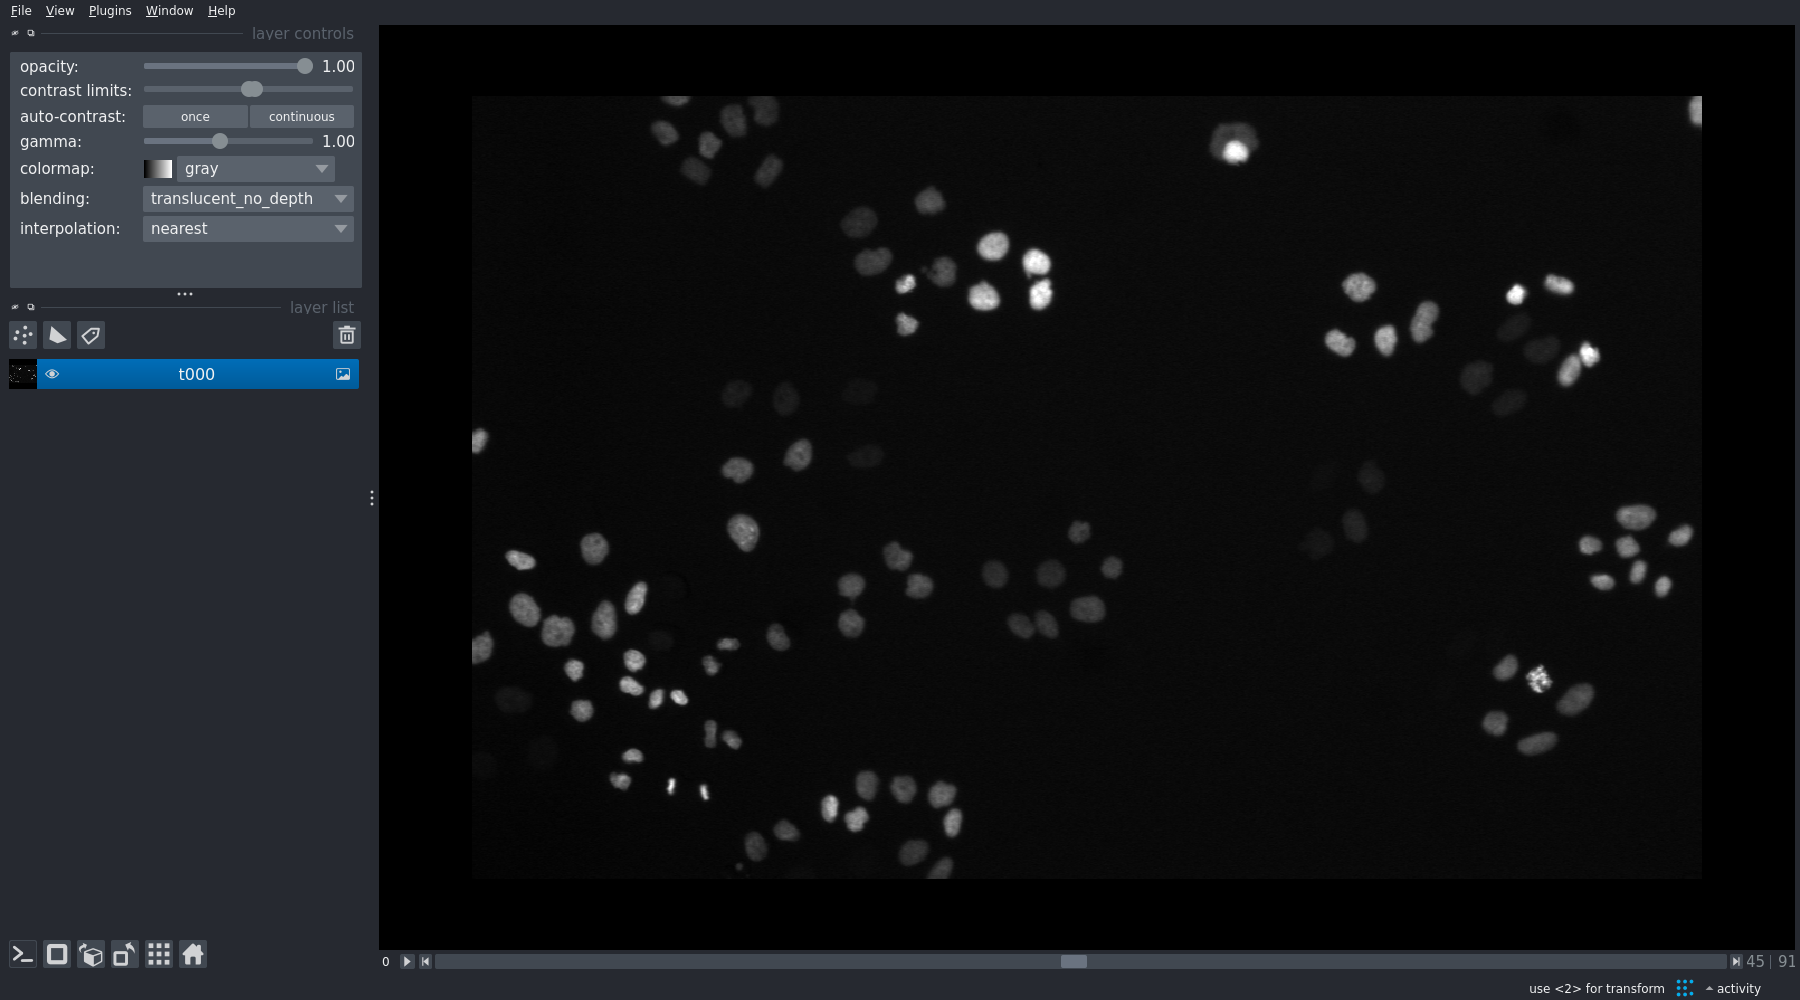

In [10]:
dataset_path = Path("Fluo-N2DL-HeLa/01")

viewer = napari.Viewer()
viewer.window.resize(1800, 1000)
viewer.open(sorted(dataset_path.glob("*.tif")), stack=True)

image = viewer.layers[0].data

nbscreenshot(viewer)

However, `ultrack` only works for single-file images. So we need to convert its format to work with the API.

In [11]:
image_path = os.path.abspath("data.tif")

imwrite(image_path, image)

The next step is to select the desired pipeline configuration. Since in this stage we only have the intensity image, we can use the `auto detection` pipeline. 

To proceed, the server requires a `MainConfig` configuration object with the desired parameters. If you don't have one in hand, you can get the default configuration directly from the server.

In [12]:
response = requests.get(f"http://localhost:{port}/config/default")

main_config = None
if response.status_code == 200:
    print('Success!')
    main_config = MainConfig.parse_raw(response.text)
    main_config.segmentation_config.n_workers = 8
    pprint(main_config)
else:
    print("Something went wrong:", response)

Success!


MainConfig(
│   data_config=None,
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=100,
│   │   max_area=1000000,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x79d35f107100>,
│   │   n_workers=8
│   ),
│   linking_config=LinkingConfig(
│   │   n_workers=1,
│   │   max_neighbors=5,
│   │   max_distance=15.0,
│   │   distance_weight=0.0,
│   │   z_score_threshold=5.0
│   ),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-0.001,
│   │   disappear_weight=-0.001,
│   │   division_weight=-0.001,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=0.001,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=-1,
│   │   link_function='power',
│   │   power=4.0,
│   │   bias=-0.0
│   )
)

Now, we must configure our whole experiment configuration. Since we want to use the `auto detection` pipeline, we must provide our image path and the parameters for its internal functions `detect_foreground` and `robust_invert`. Check the [rest API documentation](https://royerlab.github.io/ultrack/rest_api.html) for further information on those parameters.

In [13]:
new_experiment = APIExperiment(
    image_channel_or_path=image_path,
    name="A new experiment",
    config=main_config
)


new_experiment_dict = {}
new_experiment_dict["experiment"] = new_experiment.dict(exclude_none=True)
new_experiment_dict["detect_foreground_kwargs"] = {}
new_experiment_dict["robust_invert_kwargs"] = {}

Here, we start our connection to the websocket server. Upon connection, the server awaits our experiment configuration. Once it receives it, it starts sending the updated experiment instance.

In [14]:
async def websocket_client():
    uri = f"ws://127.0.0.1:{port}/segment/auto_detect"
    async with websockets.connect(uri, ping_interval=None, max_size=2*10**13) as websocket:
        # Send the experiment
        await websocket.send(json.dumps(new_experiment_dict))

        # Receive the recurrent experiment update
        try:
            finished = False
            while not finished:
                response = await websocket.recv()
                experiment = APIExperiment.parse_obj(json.loads(response))
                clear_output(wait=True)
                print(f"Experiment has the current status of {experiment.status}")
                print(experiment.err_log, file=sys.stderr)
                print(experiment.std_log)
                if experiment.status == ExperimentStatus.SUCCESS or experiment.status == ExperimentStatus.FAILED:
                    finished = True
        except ConnectionClosedError as e:
            print(f"Connection closed: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

    return experiment
# Run the client
experiment = await websocket_client()

Experiment has the current status of success
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Solving ILP ...
Saving solution ...
Done!


Opening Files: 1it [00:00, 20.88it/s]
/data_lids/home/ilansilva/PycharmProjects/ultrack-dev/ultrack/utils/array.py:190: FutureWarning: The NestedDirectoryStore is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.
  store = zarr.NestedDirectoryStore(str(store_or_path))
Applying detect_foreground ...:  98%|#########7| 90/92 [00:04<00:00, 66.94it/s]Applying detect_foreground ...: 100%|##########| 92/92 [00:04<00:00, 20.97it/s]
/data_lids/home/ilansilva/PycharmProjects/ultrack-dev/ultrack/utils/array.py:190: FutureWarning: The NestedDirectoryStore is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.
  store = zarr.NestedDirectoryStore(str(store_or_path))
Applying robust_invert ...:  78%|#######8  | 72/92 [00:01<00:00, 72.24it/s]Applying robust_invert ...: 100%|##########| 92/92 [00:01<00:00, 49.74it/s]
Op

In [15]:
pprint(experiment, max_length=2)

Experiment(
│   id=1,
│   status=<ExperimentStatus.SUCCESS: 'success'>,
│   name='A new experiment',
│   start_time='2024-06-26T19:20:04.486398',
│   end_time='2024-06-26T19:22:31.301357',
│   std_log='Using Gurobi solver\nSolving ILP batch 0\nConstructing ILP ...\nSolving ILP ...\nSaving solution ...\nDone!',
│   err_log='Opening Files: 1it [00:00, 20.88it/s]\n/data_lids/home/ilansilva/PycharmProjects/ultrack-dev/ultrack/utils/array.py:190: FutureWarning: The NestedDirectoryStore is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.\n  store = zarr.NestedDirectoryStore(str(store_or_path))\nApplying detect_foreground ...:  98%|#########7| 90/92 [00:04<00:00, 66.94it/s]Applying detect_foreground ...: 100%|##########| 92/92 [00:04<00:00, 20.97it/s]\n/data_lids/home/ilansilva/PycharmProjects/ultrack-dev/ultrack/utils/array.py:190: FutureWarning: The NestedDirectoryStore is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.\n  store = zarr.NestedDirectoryStore(str(store_or_path))\nApplying robust_invert ...:  78%|#######8  | 72/92 [00:01<00:00, 72.24it/s]Applying robust_invert ...: 100%|##########| 92/92 [00:01<00:00, 49.74it/s]\nOpening Files: 1it [00:00,  5.67it/s]Opening Files: 1it [00:00,  5.67it/s]\nOpening Files: 1it [00:00, 63.31it/s]\nAdding nodes to database: 100%|##########| 92/92 [02:07<00:00,  1.87s/it]Adding nodes to database: 100%|##########| 92/92 [02:07<00:00,  1.39s/it]\nLinking nodes.:  97%|#########6| 88/91 [00:02<00:00, 36.25it/s]Linking nodes.: 100%|##########| 91/91 [00:02<00:00, 41.14it/s]\n/data_lids/home/ilansilva/PycharmProjects/ultrack-dev/ultrack/utils/array.py:190: FutureWarning: The NestedDirectoryStore is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.\n  store = zarr.NestedDirectoryStore(str(store_or_path))\nExporting segmentation masks:  97%|#########6| 89/92 [00:00<00:00, 223.32it/s]Exporting segmentation masks: 100%|##########| 92/92 [00:00<00:00, 232.77it/s]',
│   config={'data_config': None, 'segmentation_config': {'threshold': 0.5, 'min_area': 100, ... +6}, ... +2},
│   data_url=None,
│   image_channel_or_path=None,
│   edges_channel_or_path='/tmp/tmp4kl298o_/edges.zarr',
│   detection_channel_or_path='/tmp/tmp4kl298o_/detection.zarr',
│   labels_channel_or_path=None,
│   final_segments_url='/tmp/segments_id_exp_000001.zarr',
│   tracks={'directed': True, 'multigraph': False, ... +3}
)

Now, the segments are stored in `experiment.final_segments_url`, which we will open now alongside their corresponding tracks.

In [16]:
graph = json_graph.node_link_graph(experiment.tracks)

df = pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient="index")

viewer.add_tracks(df[["track_id", "t", "y", "x"]].values)

viewer.open(experiment.final_segments_url, layer_type="labels")

/data_lids/home/ilansilva/micromamba/envs/ultrack-flow-field/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[<Labels layer 'segments_id_exp_000001' at 0x79d2e6479bd0>]

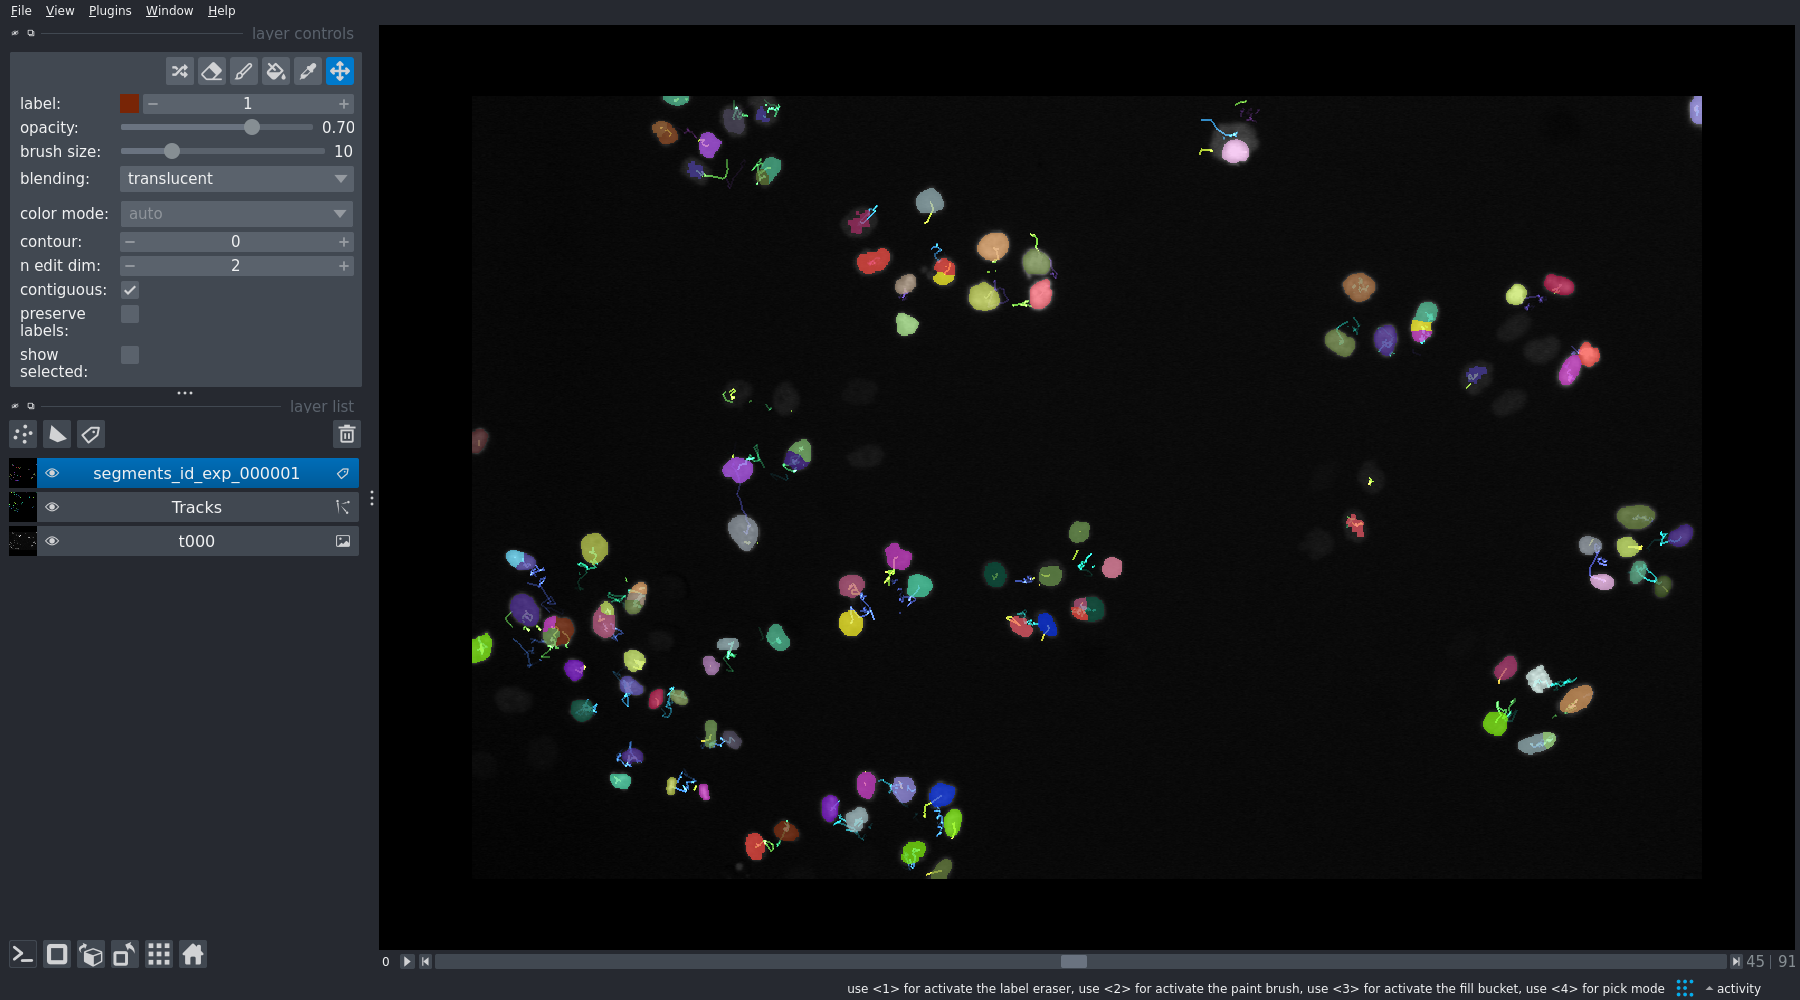

In [17]:
nbscreenshot(viewer)